<div style="text-align:center;color:Blue">
    <h2> Graph Regression with Graph Neural Networks</h2>
</div>

#### This notebook presents a thorough approach on how to apply Graph Neural Networks (GNNs) to solve a graph regression problem. 

We apply graph regression to assign one y-value to an entire graph (in contrast to nodes). 
1. We start with a dataset of graphs, based on some structural graph properties - in today's case based on lipophilicity.
2. Accordingly, entire graphs are embedded in such a way that helps us predict a molecular property prediction (a single 
lipophilicity value) for each. One can use these embeddings further to do more analysis, such as 
to classify them based on a value, such as a lipophilicity range.

Play with the model settings, data splitting, training setups etc. to get the best results from this code and any other data/model you implement based on the information provided.

#### The data: Experimental results of octanol/water distribution coefficient (logD at pH 7.4). 
Lipophilicity is an important feature of drug molecules that affects both membrane permeability 
and solubility - thus a molecule's interactivity with other molecules. 

1.	Import lipophilicity data for 4000 molecules (https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv, or use Python)
2. from PyTorch Geometric’s dataset library (https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html)
   
This Lipophilicity dataset is curated from ChEMBL database, provides experimental results of 
octanol/water distribution coefficient (logD at pH 7.4) of 4200 compounds. 
Read more: https://arxiv.org/pdf/1703.00564.pdf

In [17]:
from pandas.plotting import table
from rdkit.Chem import Draw
from rdkit import Chem
from sklearn.metrics import r2_score
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import to_networkx
from torch.nn import Linear
  
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pubchempy
import rdkit
import time
import torch
import torch.nn.functional as F 
import warnings
warnings.filterwarnings("ignore")

<div style="text-align:center;color:Blue">
    <h3> Lipophilicty dataset import (load if already imported) and explore</h3>
</div>

In [18]:
dataset = MoleculeNet(root=".", name="lipo")
data = dataset[0]

In [19]:
print('\n======== Dataset =======\n')
print("Dataset type: ", type(dataset))
print("Dataset size (graphs): ", len(dataset))
print("Dataset features: ", dataset.num_features)
print("Dataset target: ", dataset.num_classes)
print("Dataset length: ", dataset.len)
print('\n======== first sample =======\n')
print("Dataset sample: ", data)
print("Sample  nodes: ", data.num_nodes)
print("Sample  edges: ", data.num_edges)


======== Dataset =======

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset size (graphs):  4200
Dataset features:  9
Dataset target:  553
Dataset length:  <bound method InMemoryDataset.len of Lipophilicity(4200)>

======== first sample =======

Dataset sample:  Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])
Sample  nodes:  24
Sample  edges:  54


In [20]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd

# Function to compute molecular descriptors from SMILES
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # Return None for invalid SMILES
    return {
        "MolecularWeight": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
        "NumAromaticRings": Descriptors.NumAromaticRings(mol),
    }

# Load dataset (modify path accordingly)
df = pd.read_csv("/Users/sheenamittal/Desktop/work /My Projects/GNNs_drug_discovery_regression-gnn_main/lipo/raw/Lipophilicity.csv")  

# Compute descriptors for all molecules
df_descriptors = df["smiles"].apply(compute_descriptors).apply(pd.Series)

# Merge descriptors with original dataset
df = pd.concat([df, df_descriptors], axis=1)

# Save updated dataset
df.to_csv("Lipophilicity_with_descriptors.csv", index=False)
print("✅ Molecular descriptors added and saved!")


✅ Molecular descriptors added and saved!


In [21]:
# Load dataset (modify path if needed)
df = pd.read_csv("Lipophilicity_with_descriptors.csv")

# Display first few rows
print(df.head())

   CMPD_CHEMBLID   exp                                             smiles  \
0   CHEMBL596271  3.54            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14   
1  CHEMBL1951080 -1.18  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...   
2     CHEMBL1771  3.69             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl   
3   CHEMBL234951  3.37  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...   
4   CHEMBL565079  3.10  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...   

   MolecularWeight    LogP    TPSA  NumHDonors  NumHAcceptors  \
0          340.858  3.5489   24.30         0.0            4.0   
1          494.591  2.9901  122.24         2.0            7.0   
2          321.829  3.6739   29.54         0.0            4.0   
3          419.890  1.9237  105.66         4.0            5.0   
4          381.480  2.0069   99.81         2.0            5.0   

   NumRotatableBonds  NumAromaticRings  
0                3.0               3.0  
1                9.0               2.0  
2                3.0   

### Feature Distributions

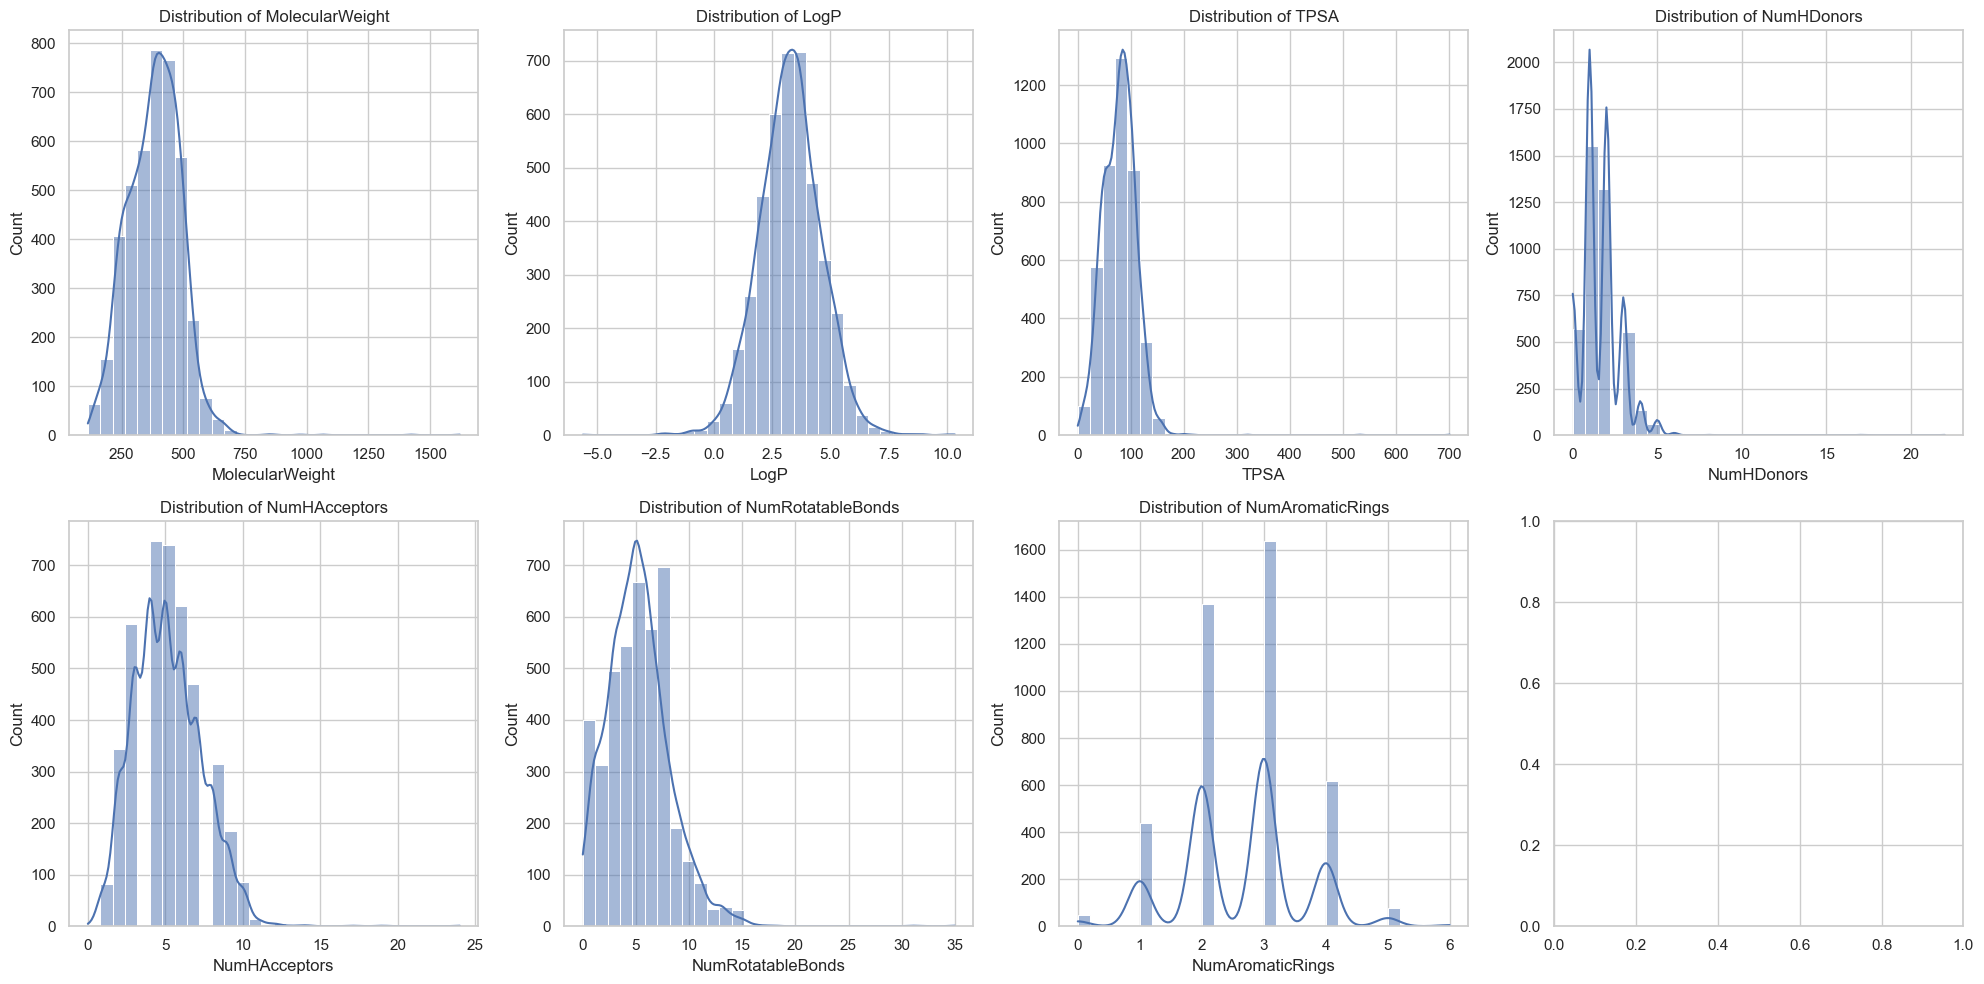

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# List of features to plot
features = ["MolecularWeight", "LogP", "TPSA", "NumHDonors", "NumHAcceptors", "NumRotatableBonds", "NumAromaticRings"]

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

# Plot each feature
for i, feature in enumerate(features):
    sns.histplot(df[feature], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


### Correlation Analysis

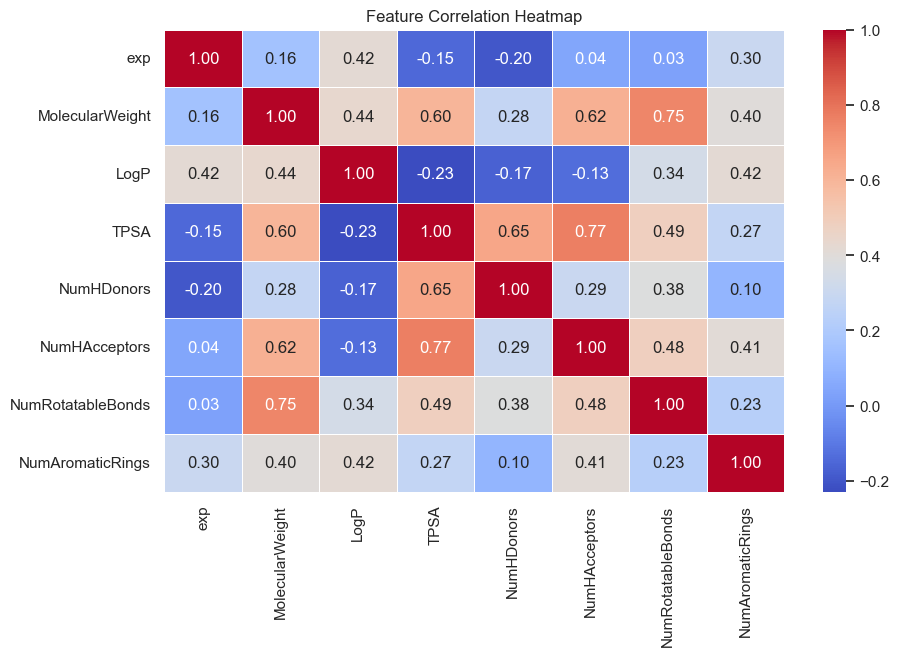

In [23]:
# Drop non-numeric columns
df_numeric = df.select_dtypes(include=["number"])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


### Identify important features

In [24]:
print(df.columns)


Index(['CMPD_CHEMBLID', 'exp', 'smiles', 'MolecularWeight', 'LogP', 'TPSA',
       'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 'NumAromaticRings'],
      dtype='object')


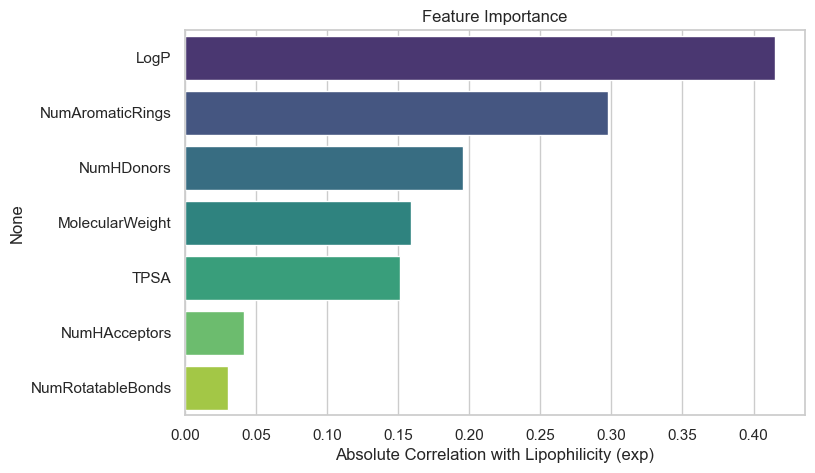

In [25]:
# Drop non-numeric columns
df_numeric = df.select_dtypes(include=["number"])

# Compute correlation matrix
correlation_matrix = df_numeric.corr()

# Sort features by correlation with lipophilicity (exp)
feature_importance = correlation_matrix["exp"].drop("exp").abs().sort_values(ascending=False)

# Plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.xlabel("Absolute Correlation with Lipophilicity (exp)")
plt.title("Feature Importance")
plt.show()


### Feature engineering (adding more features)

In [26]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from sklearn.preprocessing import MinMaxScaler

# Load the dataset
df = pd.read_csv("/Users/sheenamittal/Desktop/work /My Projects/GNNs_drug_discovery_regression-gnn_main/lipo/raw/Lipophilicity.csv")

# Convert SMILES to RDKit Molecule objects
df["mol"] = df["smiles"].apply(Chem.MolFromSmiles)

# Function to compute RDKit descriptors
def compute_rdkit_features(mol):
    if mol is None:
        return {
            "MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumHDonors": np.nan,
            "NumHAcceptors": np.nan, "NumRotatableBonds": np.nan, "NumAromaticRings": np.nan
        }
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA": Descriptors.TPSA(mol),
        "NumHDonors": Descriptors.NumHDonors(mol),
        "NumHAcceptors": Descriptors.NumHAcceptors(mol),
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),
        "NumAromaticRings": Chem.rdMolDescriptors.CalcNumAromaticRings(mol)
    }

# Compute RDKit descriptors
rdkit_features = df["mol"].apply(compute_rdkit_features).apply(pd.Series)

# Function to compute Morgan fingerprints
def compute_fingerprint(mol, radius=2, nBits=2048):
    if mol is None:
        return np.zeros(nBits)
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits))

# Compute fingerprints
fingerprint_array = np.array(df["mol"].apply(compute_fingerprint).tolist())

# Convert fingerprints to DataFrame
fingerprint_df = pd.DataFrame(fingerprint_array, columns=[f"FP_{i}" for i in range(2048)])

# Merge all features into the DataFrame
df = pd.concat([df, rdkit_features, fingerprint_df], axis=1)

# Drop unnecessary columns
df.drop(["mol", "smiles"], axis=1, inplace=True)

# Separate numeric and non-numeric columns
numeric_cols = df.select_dtypes(include=["number"]).columns

# Normalize numeric features
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

# Save processed data
df.to_csv("processed_data.csv", index=False)
print("Feature Engineering Complete! Data saved as 'processed_data.csv'.")

[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerator
[10:57:38] DEPRECATION WARNING: please use MorganGenerat

Feature Engineering Complete! Data saved as 'processed_data.csv'.
